In [1]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def process_permissions(permission_string):
    list_items = permission_string.split(',')
    processed_list = [item.strip() for item in list_items]
    processed_list = [item.replace('.', '').lower() for item in processed_list]
    
    # fixing the format of a specific string
    for i in range(len(processed_list)):
        if processed_list[i] == "add or modify calendar events and send email to guests without owners\\ knowledge":
            processed_list[i] = processed_list[i].replace('\\', '')

    return processed_list

# Study 2 - read call logs, write call logs (zijn de permissions van het artikel van Ksenia) over alle apps

## Loading, cleaning, preparing

In [3]:
google_data_first = pd.read_csv('../../data/google_data_first.csv', encoding='ISO-8859-1')

In [4]:
google_data_first.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
google_data_first = google_data_first.dropna(subset=['permissions', 'nb_rating'])

In [6]:
google_data_first['processed_permissions'] = google_data_first['permissions'].apply(process_permissions)

In [7]:
apps_with_call_logs_permissions = google_data_first[google_data_first['processed_permissions'].apply(lambda x: 'read call log' in x or 'write call log' in x)]

In [8]:
google_data_last = pd.read_csv('../../data/google_data_last.csv', encoding='ISO-8859-1')

In [9]:
google_data_last.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
google_data_last = google_data_last.dropna(subset=['permissions', 'nb_rating'])

In [11]:
google_data_last['processed_permissions'] = google_data_last['permissions'].apply(process_permissions)

In [12]:
apps_with_call_logs_permissions_last = google_data_last[google_data_last['processed_permissions'].apply(lambda x: 'read call log' in x or 'write call log' in x)].copy()

In [13]:
# filter nb_rating to only include apps with more than 80 ratings, first cast to int and remove commas
apps_with_call_logs_permissions_last['nb_rating'] = apps_with_call_logs_permissions_last['nb_rating'].astype(str).str.replace(',', '').astype(int)
apps_with_call_logs_permissions_last = apps_with_call_logs_permissions_last[apps_with_call_logs_permissions_last['nb_rating'] > 112]

In [14]:
google_data_first['year'] = 2018
google_data_last['year'] = 2019

In [15]:
combined_data_new = pd.concat([google_data_first, google_data_last])

In [16]:
# only the apps that have my_app_id in apps_with_call_logs_permissions
combined_data_new = combined_data_new[combined_data_new['my_app_id'].isin(apps_with_call_logs_permissions['my_app_id'])]

In [17]:
# Filter to include only apps present in both 2018 and 2019
apps_in_both_years = combined_data_new.groupby('my_app_id').filter(lambda x: x['year'].nunique() == 2).copy()

In [18]:
apps_in_both_years['treatment_group'] = apps_in_both_years['my_app_id'].isin(apps_with_call_logs_permissions['my_app_id']) & ~apps_in_both_years['my_app_id'].isin(apps_with_call_logs_permissions_last['my_app_id'])
apps_in_both_years['control_group'] = apps_in_both_years['my_app_id'].isin(apps_with_call_logs_permissions['my_app_id']) & apps_in_both_years['my_app_id'].isin(apps_with_call_logs_permissions_last['my_app_id'])


In [19]:
apps_in_both_years['post_policy'] = (apps_in_both_years['year'] == 2019).astype(bool)

In [20]:
# extract all PEGI ratings from the content_rating_app column
apps_in_both_years['PEGI_rating'] = apps_in_both_years['content_rating_app'].str.extract('PEGI\s(\d+)')
# fill NaN with '0'
apps_in_both_years['PEGI_rating'].fillna('0', inplace=True)
# Convert to int
apps_in_both_years['PEGI_rating'] = apps_in_both_years['PEGI_rating'].astype(int)

In [21]:
# change booleans to ints
apps_in_both_years['in_app'] = apps_in_both_years['in_app'].astype(int)
apps_in_both_years['has_ads'] = apps_in_both_years['has_ads'].astype(int)

In [22]:
# Function to convert strings to integers
def convert_to_int(download_str):
    # Remove non-numeric characters
    clean_str = ''.join(filter(str.isdigit, download_str))
    # Convert to integer
    return int(clean_str)

apps_in_both_years['num_downloads_numeric'] = apps_in_both_years['num_downloads'].apply(convert_to_int)
apps_in_both_years['log_num_downloads'] = np.log(apps_in_both_years['num_downloads_numeric'])
apps_in_both_years['num_ratings_numeric'] = apps_in_both_years['nb_rating'].apply(convert_to_int)
apps_in_both_years['log_num_ratings'] = np.log(apps_in_both_years['num_ratings_numeric'])

In [23]:
apps_in_both_years = pd.get_dummies(apps_in_both_years, columns=['PEGI_rating'], dtype=int)

In [24]:
apps_in_both_years.groupby(['treatment_group', 'post_policy']).count()['year']

treatment_group  post_policy
False            False           371
                 True            371
True             False          3055
                 True           3055
Name: year, dtype: int64

# DID

In [25]:
# Formula for the DiD model
# The interaction term (treatment_group:post_policy) is the DiD estimator
formulas = [
    'rating_app ~ treatment_group + post_policy + treatment_group:post_policy',
    'rating_app ~ treatment_group + post_policy + treatment_group:post_policy + log_num_downloads + log_num_ratings',
    'rating_app ~ treatment_group + post_policy + treatment_group:post_policy + log_num_downloads + log_num_ratings + in_app + has_ads',
    'rating_app ~ treatment_group + post_policy + treatment_group:post_policy + log_num_downloads + log_num_ratings + in_app + has_ads + PEGI_rating_0 + PEGI_rating_7 + PEGI_rating_12 + PEGI_rating_16',]

models = [smf.ols(formula=formula, data=apps_in_both_years).fit() for formula in formulas]
# Running the regression
#model = smf.ols(formula=formula, data=apps_in_both_years).fit()

# Output the summary of the regression results
for model in models:
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     35.61
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           7.96e-23
Time:                        23:39:57   Log-Likelihood:                -6119.1
No. Observations:                6852   AIC:                         1.225e+04
Df Residuals:                    6848   BIC:                         1.227e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

## Model presentation

In [26]:
# Combining the model summaries into one table
summary_table = summary_col(models, 
                                    stars=True, 
                                    model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
                                    info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                               'Adj. R-squared': lambda x: f"{x.rsquared_adj:.2f}",
                                               'AIC': lambda x: f"{x.aic:.0f}",
                                               'BIC': lambda x: f"{x.bic:.0f}"},
                                    float_format="%0.3f")

# Generating the combined summary table in LaTeX format
summary_table_latex = summary_table.as_latex()
print(summary_table_latex)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                                              & Model 1  & Model 2   & Model 3   & Model 4    \\
\hline
Intercept                                     & 3.841*** & 4.047***  & 4.100***  & 4.098***   \\
                                              & (0.031)  & (0.046)   & (0.046)   & (0.046)    \\
treatment\_group[T.True]                      & 0.257*** & 0.303***  & 0.268***  & 0.268***   \\
                                              & (0.033)  & (0.032)   & (0.032)   & (0.032)    \\
post\_policy[T.True]                          & 0.021    & 0.010     & 0.011     & 0.011      \\
                                              & (0.043)  & (0.042)   & (0.042)   & (0.042)    \\
treatment\_group[T.True]:post\_policy[T.True] & -0.046   & -0.038    & -0.038    & -0.038     \\
                                              & (0.046)  & (0.045)   & (0.044)   & (0.044)    \\
log\_num\_downloads                      

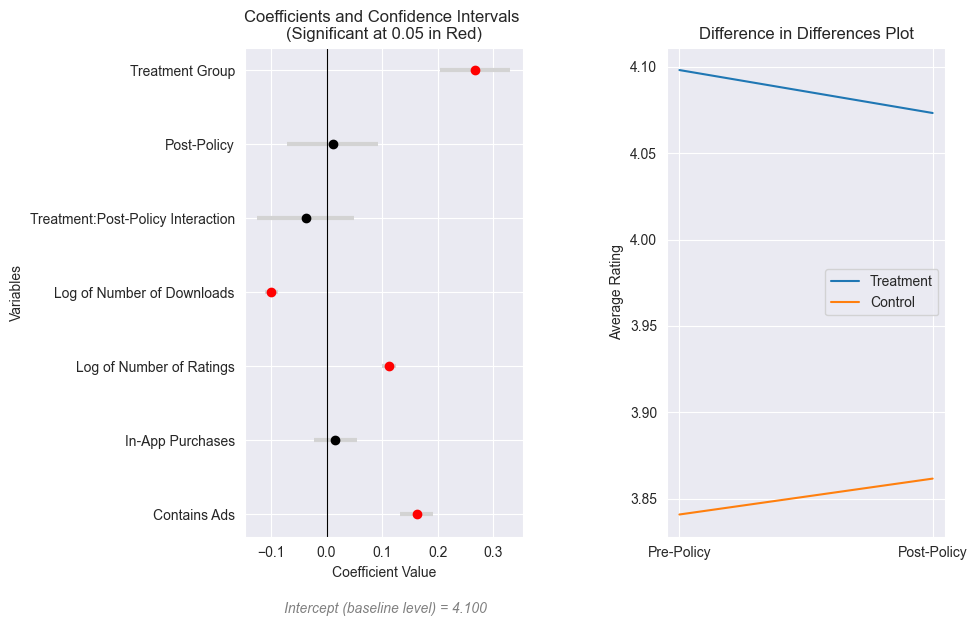

In [27]:
# Compute means directly for each group and time period
means = {}
for treatment in [True, False]:
    for post in [True, False]:
        means[(treatment, post)] = apps_in_both_years[(apps_in_both_years['treatment_group'] == treatment) & (apps_in_both_years['post_policy'] == post)]['rating_app'].mean()

# Creating subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plotting the DiD plot on the first subplot
axes[1].set_title('Difference in Differences Plot')
axes[1].set_ylabel('Average Rating')
for treatment in [True, False]:
    axes[1].plot(['Pre-Policy', 'Post-Policy'], [means[(treatment, False)], means[(treatment, True)]], label=f'{"Treatment" if treatment else "Control"}')
axes[1].legend()

# Custom function adapted to use subplot for model summary
def plot_model_summary_custom(model, ax, variable_order=None, name_mapping=None, significance_level=0.05):
    coefficients = model.params.drop('Intercept')
    confidence_intervals = model.conf_int().loc[coefficients.index]
    p_values = model.pvalues.drop('Intercept')

    if variable_order:
        coefficients = coefficients.loc[variable_order]
        confidence_intervals = confidence_intervals.loc[variable_order]
        p_values = p_values.loc[variable_order]

    variables = [name_mapping.get(var, var) for var in coefficients.index]

    for i, var in enumerate(variables):
        original_var = coefficients.index[i]
        color = 'red' if p_values[original_var] < significance_level else 'black'
        ax.errorbar(x=coefficients[original_var], y=i, 
                    xerr=[[coefficients[original_var] - confidence_intervals.loc[original_var][0]], 
                          [confidence_intervals.loc[original_var][1] - coefficients[original_var]]], 
                    fmt='o', color=color, ecolor='lightgray', elinewidth=3, capsize=0)
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.set_yticks(ticks=np.arange(len(variables)))
    ax.set_yticklabels(variables)
    ax.set_title('Coefficients and Confidence Intervals \n(Significant at 0.05 in Red)')
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Variables')
    ax.grid(True)

variable_order = [
    "has_ads",
    "in_app",
    "log_num_ratings",
    "log_num_downloads",
    "treatment_group[T.True]:post_policy[T.True]",
    "post_policy[T.True]",
    "treatment_group[T.True]"
]

name_mapping = {
    "treatment_group[T.True]": "Treatment Group",
    "post_policy[T.True]": "Post-Policy",
    "treatment_group[T.True]:post_policy[T.True]": "Treatment:Post-Policy Interaction",
    "log_num_downloads": "Log of Number of Downloads",
    "log_num_ratings": "Log of Number of Ratings",
    "in_app": "In-App Purchases",
    "has_ads": "Contains Ads"
}

# Plotting the custom model summary plot on the second subplot
plot_model_summary_custom(models[2], axes[0], variable_order=variable_order, name_mapping=name_mapping)

plt.subplots_adjust(wspace=200)
plt.tight_layout()
plt.figtext(0.39, -0.03, "Intercept (baseline level) = 4.100", ha="center", fontsize=10, color="gray", fontstyle='italic')
plt.show()
